In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression

from sklearn.decomposition import PCA
import missingno as msno


In [2]:
sample_submission_df = pd.read_csv("sample_submission.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df["train_test"] = 0
test_df["train_test"] = 1

data = pd.concat([train_df, test_df])
data.reset_index(inplace=True)
data.drop("index", axis=1, inplace=True)
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train_test
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN,1
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN,1
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN,1
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN,1


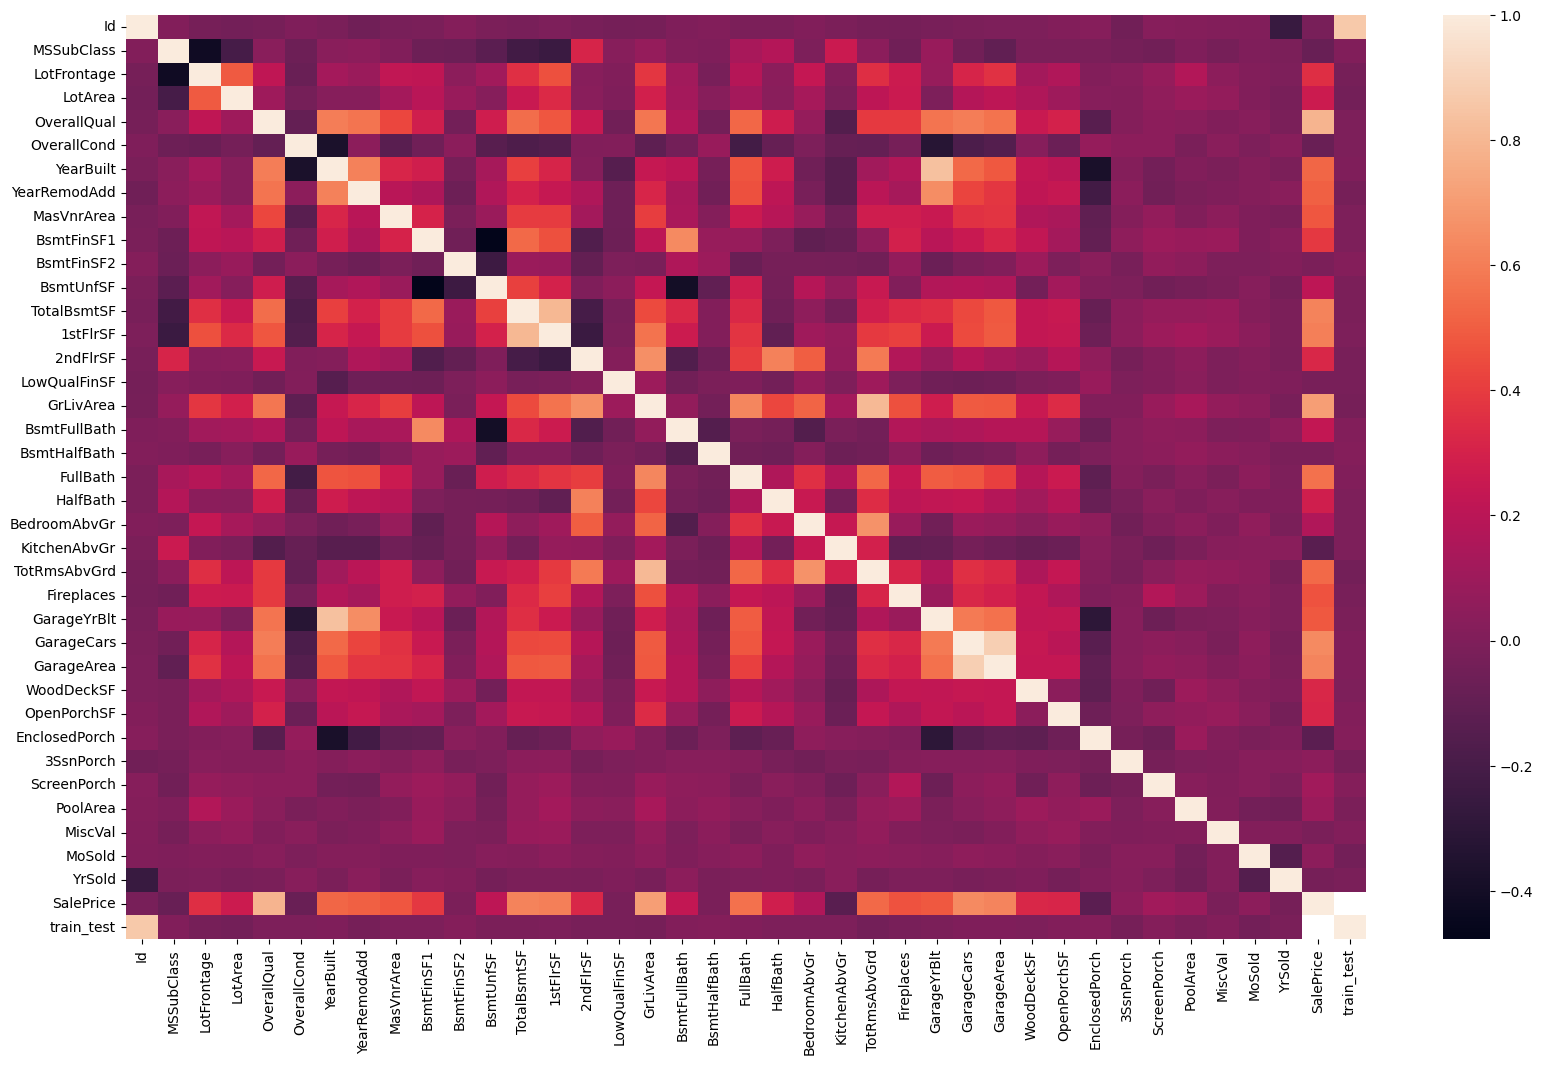

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
train_test  

In [4]:
numerical_df = data.select_dtypes(include=["float", "int"])
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix)
plt.show()

print(correlation_matrix["SalePrice"].sort_values(ascending=False))

# Data Preprocessing

In [5]:
missing_columns_train = train_df.columns[train_df.isna().any()].tolist()
missing_columns_test = test_df.columns[test_df.isna().any()].tolist()
all_missing_columns = set(missing_columns_train + missing_columns_test)
print(f"Columns with missing data in train dataset: {missing_columns_train}")
print(f"Columns with missing data in test dataset: {missing_columns_test}")
all_missing_columns


Columns with missing data in train dataset: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Columns with missing data in test dataset: ['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


{'Alley',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'Electrical',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'KitchenQual',
 'LotFrontage',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'PoolQC',
 'SaleType',
 'TotalBsmtSF',
 'Utilities'}

In [6]:
target = train_df.SalePrice
data = data.drop("SalePrice", axis=1)

### Split data into Numerical and Categorical Data

In [7]:
numerical_df = data.select_dtypes(include=["float", "int"])
categorical_df = data.select_dtypes(include=["category", "object"])

## Categorical Data Preprocessing 

In [8]:
categorical_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


## One Hot Encoding

In [9]:
columns_with_nans = categorical_df.isna().any()
columns_with_nans = columns_with_nans[columns_with_nans].index.tolist()

# Columns suitable for one-hot encoding
one_hot_columns = [
    "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities",
    "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2",
    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
    "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical", "GarageType",
    "PavedDrive", "MiscFeature", "SaleType", "SaleCondition"
]

columns_one_hot = columns_with_nans + one_hot_columns
nan_categorical_df = categorical_df[columns_one_hot]
one_hot_df = pd.get_dummies(nan_categorical_df, dtype=int)
one_hot_df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_Pave,Utilities_AllPub,Utilities_NoSeWa,Exterior1st_AsbShng,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


## Ordinal Encoding

In [10]:
ordinal_encoder = OrdinalEncoder()
ordinal_df = categorical_df.drop(columns_one_hot, axis=1)

# Define the specific order for ordinal encoding
order = [
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # ExterQual,
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # ExterCond
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # HeatingQC
]

encoder = OrdinalEncoder(categories=order)
df_encoded = encoder.fit_transform(ordinal_df)
df_encoded = pd.DataFrame(df_encoded, columns=['ExterQual_Encoded', 'ExterCond_Encoded', 'HeatingQC_Encoded'])
categorical_df_processed = pd.concat([df_encoded, one_hot_df], axis=1)
categorical_df_processed.head()

,ExterQual_Encoded,ExterCond_Encoded,HeatingQC_Encoded,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.0,2.0,4.0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,2.0,2.0,4.0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,3.0,2.0,4.0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,2.0,2.0,3.0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,3.0,2.0,4.0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## Numerical Data

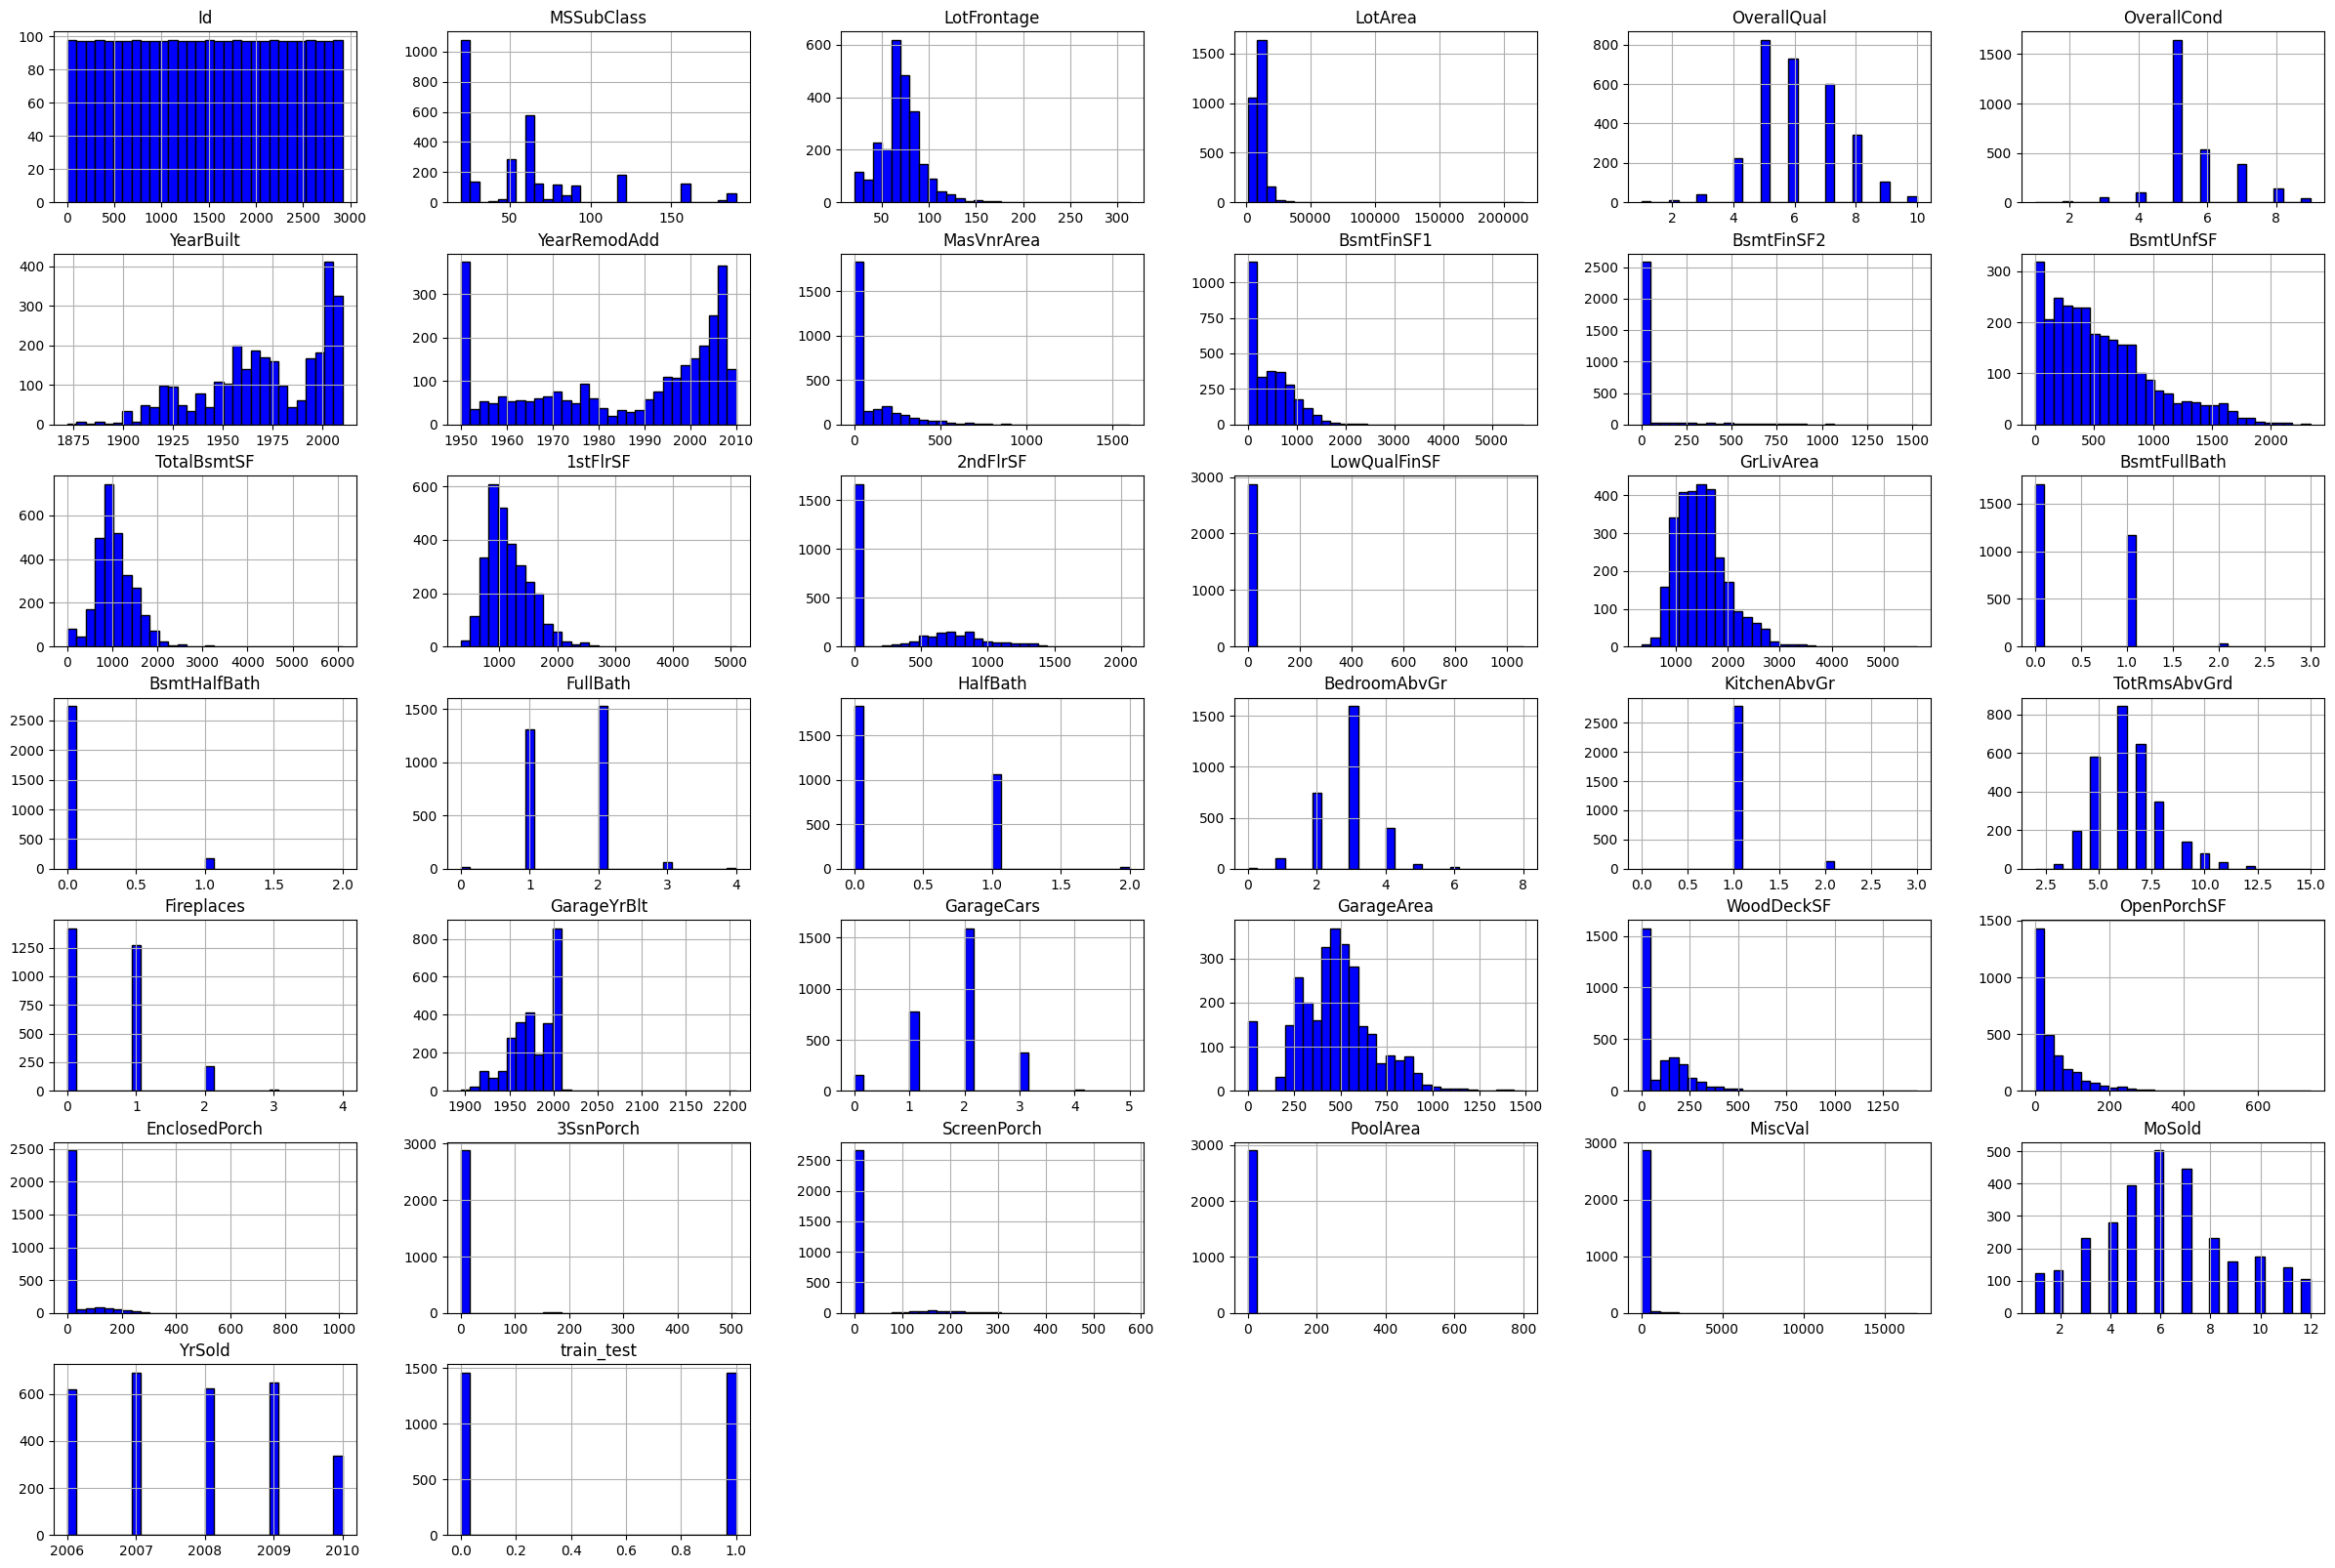

In [11]:
numerical_df.hist(figsize=(30,20), bins=30, color='blue', edgecolor='black')
plt.show()

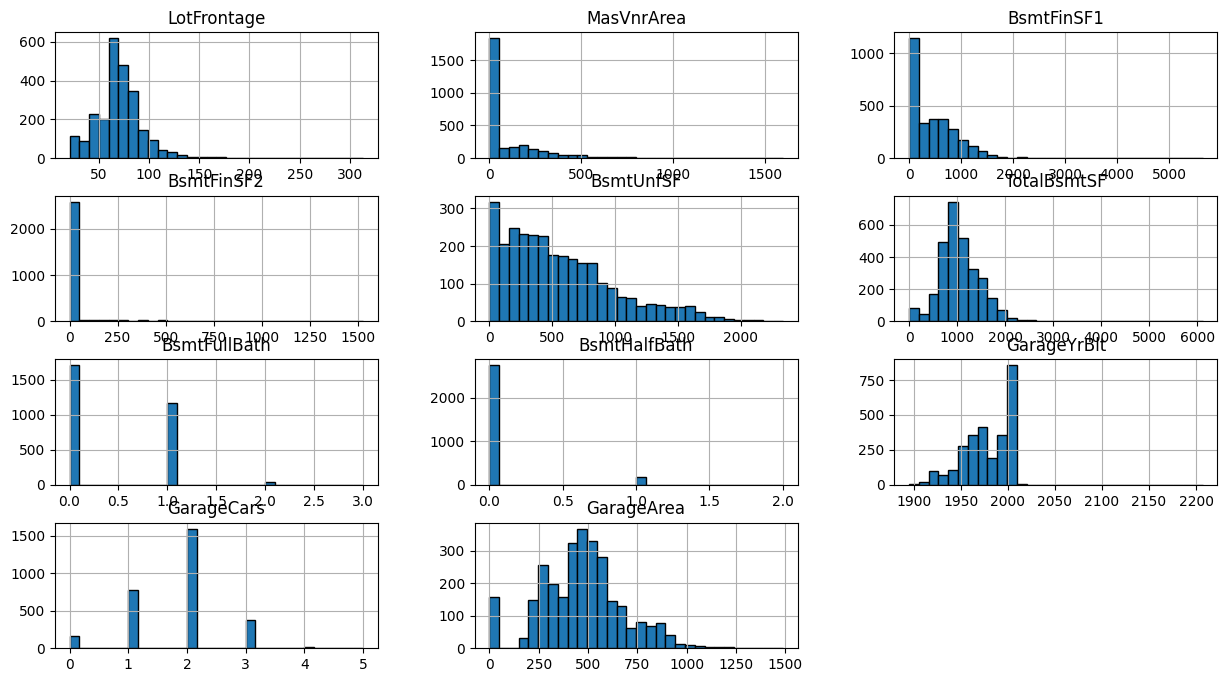

In [12]:
numerical_nans = numerical_df.isna().any()
numerical_nans = numerical_nans[numerical_nans].index.tolist()
numerical_df_nans = numerical_df[numerical_nans]
numerical_df.drop(numerical_nans, axis=1, inplace=True)
numerical_df_nans.hist(figsize=(15,8), bins=30, edgecolor='black')
plt.show()

In [13]:
numerical_df_nans.head()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
0,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.0,2.0,548.0
1,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.0,2.0,460.0
2,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.0,2.0,608.0
3,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.0,3.0,642.0
4,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.0,3.0,836.0


In [14]:
from scipy.stats import skew
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

class SkewnessImputer():
    def __init__(self, skew_threshold=0.5):
        # Imputers will be initialized during fitting
        self.imputers = {}
        self.skew_threshold = skew_threshold  # Skewness threshold to decide on median or mean
        
    def fit(self, X, y=None):
        # Determine the imputation strategy based on skewness
        for column in X.columns:
            column_skew = skew(X[column].dropna())
            if abs(column_skew) > self.skew_threshold:  # Check absolute skewness
                # Significant skewness, use median
                self.imputers[column] = SimpleImputer(strategy='median')
            else:
                # Low skewness, use mean
                self.imputers[column] = KNNImputer(n_neighbors=10)
            self.imputers[column].fit(X[[column]])
        return self
    
    def transform(self, X, y=None):
        for column, imputer in self.imputers.items():
            X[column] = imputer.transform(X[[column]])
        return X


In [15]:
from sklearn.pipeline import Pipeline

# Define the pipeline
pipeline = Pipeline([
    ('skew_imputer', SkewnessImputer(skew_threshold=1.0)), 
    
])

numerical_df_nans_transformed = pipeline.fit_transform(numerical_df_nans)
numerical_df_processed = pd.concat([numerical_df_nans_transformed, numerical_df], axis=1)
numerical_df_processed

C:\Users\William Hazen\AppData\Local\Temp\ipykernel_18468\375013719.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = imputer.transform(X[[column]])
C:\Users\William Hazen\AppData\Local\Temp\ipykernel_18468\375013719.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = imputer.transform(X[[column]])
C:\Users\William Hazen\AppData\Local\Temp\ipykernel_18468\375013719.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,train_test
0,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.000000,2.0,...,0,61,0,0,0,0,0,2,2008,0
1,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.000000,2.0,...,298,0,0,0,0,0,0,5,2007,0
2,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.000000,2.0,...,0,42,0,0,0,0,0,9,2008,0
3,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.000000,3.0,...,0,35,272,0,0,0,0,2,2006,0
4,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.000000,3.0,...,192,84,0,0,0,0,0,12,2008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,21.0,0.0,0.0,0.0,546.0,546.0,0.0,0.0,1978.113406,0.0,...,0,0,0,0,0,0,0,6,2006,1
2915,21.0,0.0,252.0,0.0,294.0,546.0,0.0,0.0,1970.000000,1.0,...,0,24,0,0,0,0,0,4,2006,1
2916,160.0,0.0,1224.0,0.0,0.0,1224.0,1.0,0.0,1960.000000,2.0,...,474,0,0,0,0,0,0,9,2006,1
2917,62.0,0.0,337.0,0.0,575.0,912.0,0.0,1.0,1978.113406,0.0,...,80,32,0,0,0,0,700,7,2006,1


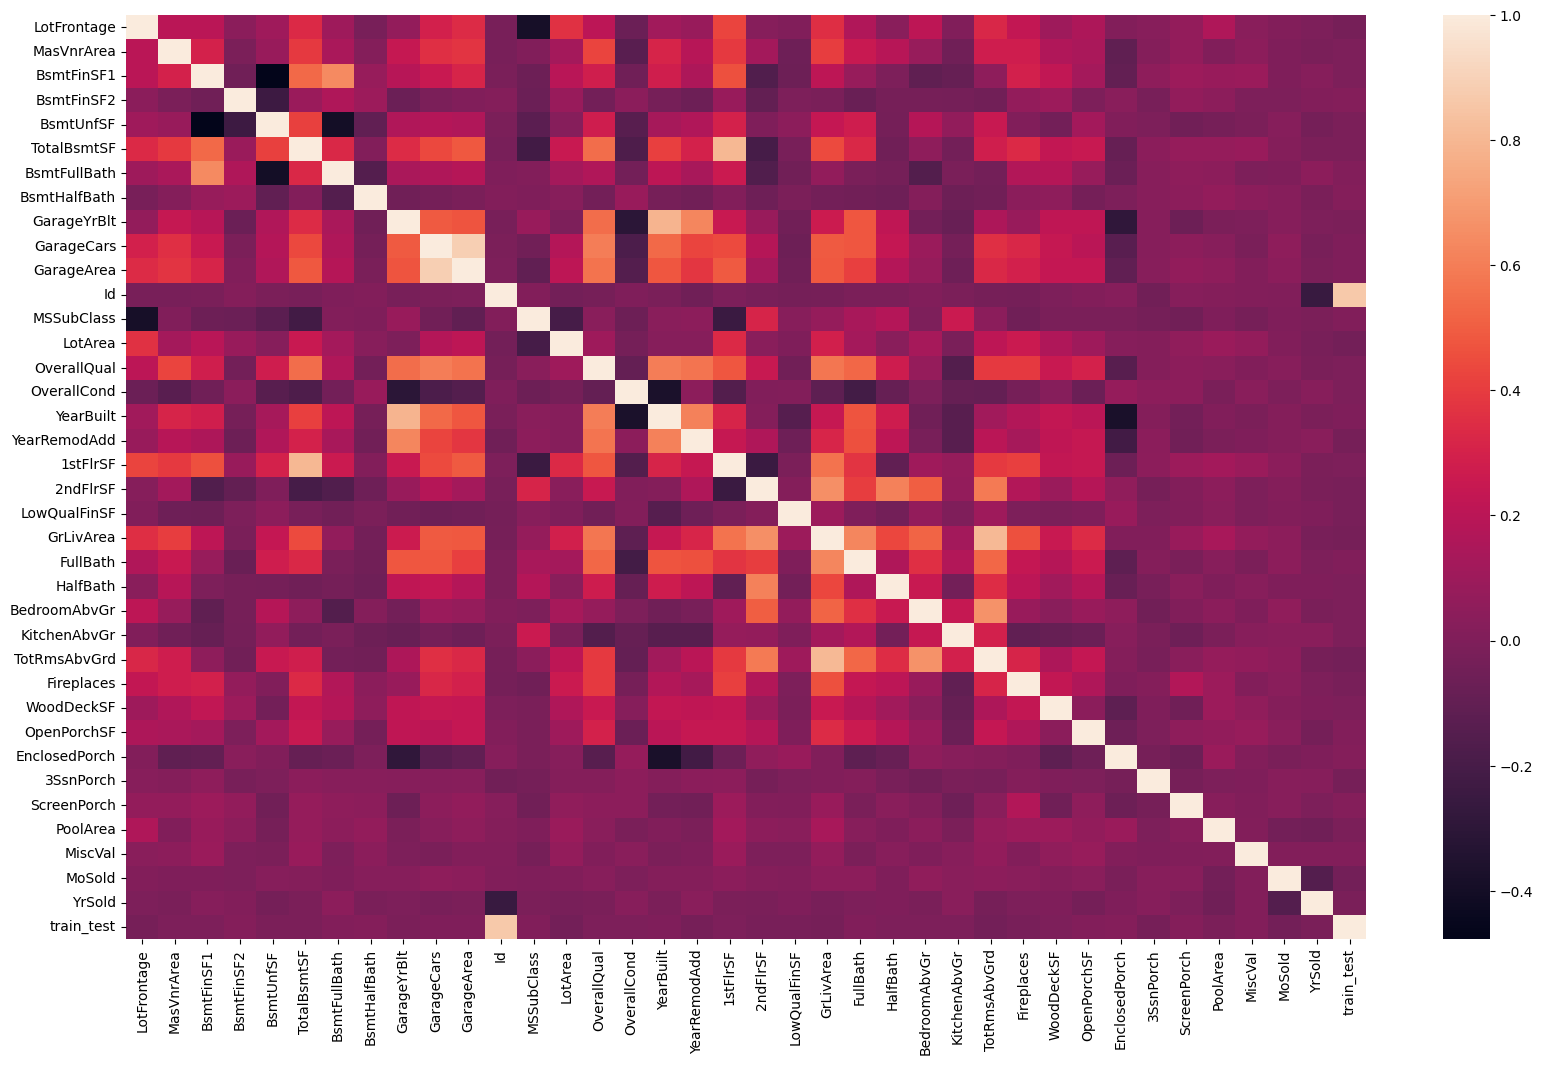

In [16]:
correlation_matrix = numerical_df_processed.corr()
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix)
plt.show()

# Train Test Split

In [17]:
df = pd.concat([numerical_df_processed, categorical_df_processed], axis=1)
df_train = df[df["train_test"] == 0]
df_test = df[df["train_test"] == 1]

df_train.drop("train_test", axis=1, inplace=True)
df_test.drop("train_test", axis=1, inplace=True)

C:\Users\William Hazen\AppData\Local\Temp\ipykernel_18468\1214669424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop("train_test", axis=1, inplace=True)
C:\Users\William Hazen\AppData\Local\Temp\ipykernel_18468\1214669424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop("train_test", axis=1, inplace=True)


In [18]:
df_train.head()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.0,2.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.0,2.0,...,0,0,0,1,0,0,0,0,1,0
2,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.0,2.0,...,0,0,0,1,0,0,0,0,1,0
3,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.0,3.0,...,0,0,0,1,1,0,0,0,0,0
4,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.0,3.0,...,0,0,0,1,0,0,0,0,1,0


In [19]:
df_test.head()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,80.0,0.0,468.0,144.0,270.0,882.0,0.0,0.0,1961.0,1.0,...,0,0,0,1,0,0,0,0,1,0
1461,81.0,108.0,923.0,0.0,406.0,1329.0,0.0,0.0,1958.0,1.0,...,0,0,0,1,0,0,0,0,1,0
1462,74.0,0.0,791.0,0.0,137.0,928.0,0.0,0.0,1997.0,2.0,...,0,0,0,1,0,0,0,0,1,0
1463,78.0,20.0,602.0,0.0,324.0,926.0,0.0,0.0,1998.0,2.0,...,0,0,0,1,0,0,0,0,1,0
1464,43.0,0.0,263.0,0.0,1017.0,1280.0,0.0,0.0,1992.0,2.0,...,0,0,0,1,0,0,0,0,1,0


# Model Preprocessing

## Normalizing

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train)
X_train = pd.DataFrame(data=X_train, columns=df_train.columns)
X_test = scaler.transform(df_test)
X_test = pd.DataFrame(data=X_test, columns=df_test.columns)
y_train = target

In [21]:
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]


## Dimensionality Reduction - PCA

In [22]:
# pca = PCA(n_components=0.95) # Keeps 95% of the data variance
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Models

In [23]:
def evaluation(result_df):
    """
    Visualizes and evaluates the performance of a predictive model by comparing 
    actual and predicted values.

    This function creates several plots to provide a comprehensive understanding 
    of the model's performance, including line plots for actual vs. predicted values, 
    distribution of residuals, scatter plots, and Q-Q plots. It also calculates 
    and prints key performance metrics like RMSE, MAE, and R².

    Parameters:
    result_df (pd.DataFrame): A DataFrame containing two columns - 'Actual' and 'Predicted',
                              where each row corresponds to the actual and predicted values
                              for a specific instance.

    Outputs:
    - Line plots comparing actual and predicted values over time.
    - A histogram showing the distribution of residuals.
    - A scatter plot of actual vs. predicted values.
    - A residual plot.
    - Printed performance metrics: RMSE, MAE, R², and Standard Deviation of Actual Values.

    """
    
#     ax = result_df.plot(y='Actual', figsize=(30, 10), color='blue', linewidth=4, alpha=0.8, label='Actual')
#     result_df.plot(type="scatter", y='Predicted', color='red', linewidth=2, alpha=0.5, label='Predicted', ax=ax)
#     plt.grid(True)
#     plt.title('Actual vs Predicted Values')
#     plt.legend()
#     plt.show()
    plt.figure(figsize=(15, 10))
    range_values = range(len(result_df["Actual"]))
    plt.plot(range_values, result_df["Actual"], label="Actual Values", marker='o')
    plt.plot(range_values, result_df["Predicted"], label="Predictions", alpha=0.5, marker='x')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    
    # plt.figure(figsize=(10, 6))
    # plt.scatter(result_df["Actual"], result_df["Predicted"], alpha=0.5)
    # plt.title('Actual vs. Predicted Values')
    # plt.xlabel('Actual Values')
    # plt.ylabel('Predicted Values')
    # plt.plot([result_df["Actual"].min(), result_df["Actual"].max()], [result_df["Actual"].min(), result_df["Actual"].max()], 'k--', lw=2)  # Diagonal line
    # plt.show()



    residuals = result_df['Actual'] - result_df['Predicted']
    std_dev = result_df['Actual'].std()
    rmse = np.sqrt(mean_squared_error( result_df['Actual'], result_df['Predicted']))
    mae = mean_absolute_error( result_df['Actual'], result_df['Predicted'])
    r2 = r2_score( result_df['Actual'], result_df['Predicted'])
    print(f"Standard Deviation of Actual Values: {std_dev}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")


    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    # 1. Scatter Plot of Actual vs. Predicted Values
    sns.scatterplot(x='Actual', y='Predicted', data=result_df, ax=axes[0, 0])
    axes[0, 0].plot([result_df['Actual'].min(), result_df['Actual'].max()], 
            [result_df['Actual'].min(), result_df['Actual'].max()], 
            color='red', lw=2, linestyle='--')
    axes[0, 0].set_title('Actual vs Predicted Values')
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')

    # 2. Residual Plot
    residuals = result_df['Actual'] - result_df['Predicted']
    sns.residplot(x='Predicted', y=residuals, data=result_df, lowess=True, line_kws={'color': 'red', 'lw': 2}, ax=axes[0, 1])
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')

    # 3. Histogram of Residuals
    sns.histplot(residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Histogram of Residuals')
    axes[1, 0].set_xlabel('Residuals')

    # 4. Histogram of Actual vs Predicted Values
    axes[1, 1].hist(result_df['Actual'], bins=30, alpha=0.7, label='Actual')
    axes[1, 1].hist(result_df['Predicted'], bins=30, alpha=0.7, label='Predicted')
    axes[1, 1].grid(True)
    axes[1, 1].set_xlabel('Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].set_title('Actual vs Predicted Values')

    plt.tight_layout()
    plt.show()


In [24]:
df_train

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.0,2.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.0,2.0,...,0,0,0,1,0,0,0,0,1,0
2,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.0,2.0,...,0,0,0,1,0,0,0,0,1,0
3,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.0,3.0,...,0,0,0,1,1,0,0,0,0,0
4,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.0,3.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,0.0,0.0,0.0,953.0,953.0,0.0,0.0,1999.0,2.0,...,0,0,0,1,0,0,0,0,1,0
1456,85.0,119.0,790.0,163.0,589.0,1542.0,1.0,0.0,1978.0,2.0,...,0,0,0,1,0,0,0,0,1,0
1457,66.0,0.0,275.0,0.0,877.0,1152.0,0.0,0.0,1941.0,1.0,...,0,0,0,1,0,0,0,0,1,0
1458,68.0,0.0,49.0,1029.0,0.0,1078.0,1.0,0.0,1950.0,1.0,...,0,0,0,1,0,0,0,0,1,0


In [25]:
target.dropna()

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

## XGBoost & Multivariate Regression

In [26]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [27]:
xgboost = XGBRegressor()

mae_scores = cross_val_score(xgboost, X_train, target, cv=10, scoring="neg_mean_absolute_percentage_error")
mae_scores = -mae_scores

r2_scores = cross_val_score(xgboost, X_train, target, cv=10, scoring='r2')

# Calculate average scores
average_mae = np.mean(mae_scores)
average_r2 = np.mean(r2_scores)

print(f"Average MAE Percentage from 10-fold CV = {average_mae}")
print(f"Average R2 from 10-fold CV = {average_r2}")

Average MAE Percentage from 10-fold CV = 0.10273811438271511
Average R2 from 10-fold CV = 0.8647460467497904


- Average MAE Percentage from 10-fold CV = 0.10583050912810912
- Average R2 from 10-fold CV = 0.8598639961706873

These results show that XGBoost does have predictive power as 86% of the data can be explained with a 10.5% MAE percentage. Simply put there is a 10.5% error rate in the prediction on average.

In [28]:
xgboost = XGBRegressor()
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)

sample_submission_df["SalePrice"] = y_pred
sample_submission_df

,Id,SalePrice
0,1461,128646.835938
1,1462,166078.953125
2,1463,188948.921875
3,1464,187269.875000
4,1465,189303.390625
...,...,...
1454,2915,71862.742188
1455,2916,76001.757812
1456,2917,159123.328125
1457,2918,111166.734375


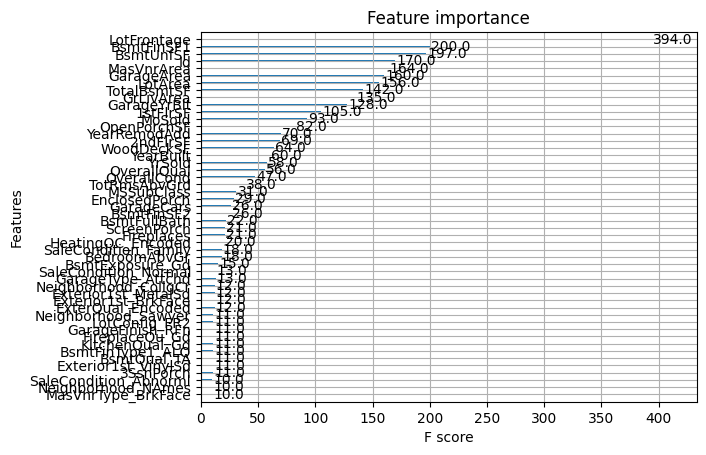

In [29]:
# Plot feature importances
xgb.plot_importance(xgboost, max_num_features=50)
plt.show()

In [30]:
# Get feature importances
feature_importances = xgboost.get_booster().get_score(importance_type='weight')

# Sort feature importances by their values
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Extract top 20 features
top_features = [feature[0] for feature in sorted_feature_importances[:50]]

# Filter your dataset to include only the top features
X_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]

# Now, train your XGBoost model using only the top features
xgboost_top_features = XGBRegressor()
xgboost_top_features.fit(X_top_features, y_train)

# Make predictions using the new model
predictions_top_features = xgboost_top_features.predict(X_test_top_features)


In [31]:
xgboost = XGBRegressor()

mae_scores = cross_val_score(xgboost, X_top_features, target, cv=10, scoring="neg_mean_absolute_percentage_error")
mae_scores = -mae_scores

r2_scores = cross_val_score(xgboost, X_top_features, target, cv=10, scoring='r2')

# Calculate average scores
average_mae = np.mean(mae_scores)
average_r2 = np.mean(r2_scores)

print(f"Average MAE Percentage from 10-fold CV = {average_mae}")
print(f"Average R2 from 10-fold CV = {average_r2}")

Average MAE Percentage from 10-fold CV = 0.10375160129886188
Average R2 from 10-fold CV = 0.8660009892424358


In [249]:
# sample_submission_df.to_csv("/kaggle/working/submission.csv", index=False)

OSError: Cannot save file into a non-existent directory: '\kaggle\working'